# waifu-classifier

## Imports

In [1]:
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *

In [2]:
# check if GPU is being used
import torch
torch.cuda.get_device_name(0)

'GeForce RTX 2060'

## Scraping

In [3]:
# get Azure API key
with open('.azure_key') as azure_keyfile:
    key = azure_keyfile.read().strip()

In [4]:
# waifus to be classified
waifu_names = [
    'ayanami_rei',
    'souryuu_asuka_langley'
]

In [5]:
# directory 
path = Path('waifus')

In [6]:
# download images of waifus
if not path.exists():
    path.mkdir()
    for waifu_name in waifu_names:
        destination = path/waifu_name
        destination.mkdir(exist_ok=True)
        urls = search_images_bing(key, waifu_name).attrgot('contentUrl')
        download_images(destination, urls=urls)

In [7]:
# get paths to each image
filepaths = get_image_files(path)
# remove problematic images
failed = verify_images(filepaths)
failed.map(Path.unlink)

(#0) []

## Data

In [8]:
waifus = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms()
)

In [9]:
dls = waifus.dataloaders(path)

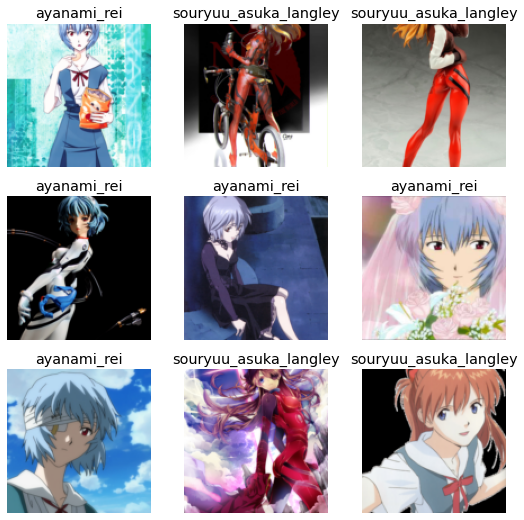

In [10]:
dls.valid.show_batch()

## Model

In [11]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

In [12]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.321234,0.524994,0.227273,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.660789,0.323682,0.090909,00:07
1,0.654604,0.112642,0.045455,00:07
2,0.549589,0.046624,0.000000,00:08
3,0.469281,0.023255,0.000000,00:07
4,0.410989,0.014056,0.000000,00:07
5,0.357068,0.010186,0.000000,00:08
6,0.321803,0.009149,0.000000,00:09
7,0.293310,0.008159,0.000000,00:09
8,0.265839,0.007151,0.000000,00:08
9,0.236646,0.007862,0.000000,00:07


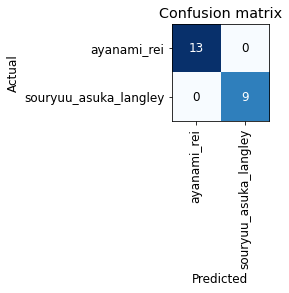

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

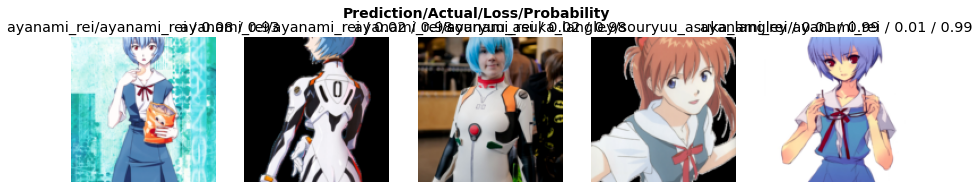

In [27]:
interp.plot_top_losses(5, nrows=1)

In [22]:
# export model safely (no accidental overwriting)
if not Path('export.pkl').exists():
    learn.export()

## Inference

In [23]:
learn_inf = load_learner('export.pkl')

In [24]:
learn_inf.predict('test/asuka.jpg') # should be asuka

('souryuu_asuka_langley', tensor(1), tensor([0.0035, 0.9965]))

In [25]:
learn_inf.predict('test/rei.jpg') # should be rei

('ayanami_rei', tensor(0), tensor([0.9988, 0.0012]))